In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil
import math
from gaussian_functions import *
from DM_halo_functions import *
from GC_functions import *
from modified_GC_functions import *
from Re_functions import *
import itertools

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)


## list of all parameters:
# R_es in kpc
# GC_masses in in units of 1e5 solar masses
# DM halo masses in solar masses
trial_num = 'M9_modified_GC_20_0.5dex'
param_values = np.load('param_values/param_values_trial'+str(trial_num)+'.npy')
R_es = param_values[:,0]  #R_es in pc
GC_masses = param_values[:,1]  #total GC mass in Solar Mass
halo_masses = param_values[:,2]  #DM halo in log Solar Mass

R_es = R_es/1000  #kpc
GC_masses = GC_masses*10**(-5) #1e5 solar masses

n = 1

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/ipykernel_launcher.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Finished calculating NFW Energies and Weights
6.000240325927734
1 2.0174698353233014
finished until t = 0.0 1.191803216934204
finished until t = 0.5 13.36122179031372
finished until t = 1.0 36.79806303977966
finished until t = 1.5 72.01763105392456
finished until t = 2.0 119.40853381156921
finished until t = 2.5 179.07929396629333
finished until t = 3.0 251.28633093833923
finished until t = 3.5 336.4824960231781
finished until t = 4.0 433.7823836803436
finished until t = 4.5 543.9970393180847
finished until t = 5.0 667.5628244876862
finished until t = 5.5 804.531409740448
finished until t = 6.0 954.1913130283356
finished until t = 6.5 1116.7175858020782
finished until t = 7.0 1292.2659964561462
finished until t = 7.5 1482.247686624527
finished until t = 8.0 1685.7882957458496
finished until t = 8.5 1902.38578748703
finished until t = 9.0 2132.356076002121
finished until t = 9.5 2377.1184208393097
finished until t = 10.0 2637.27823472023


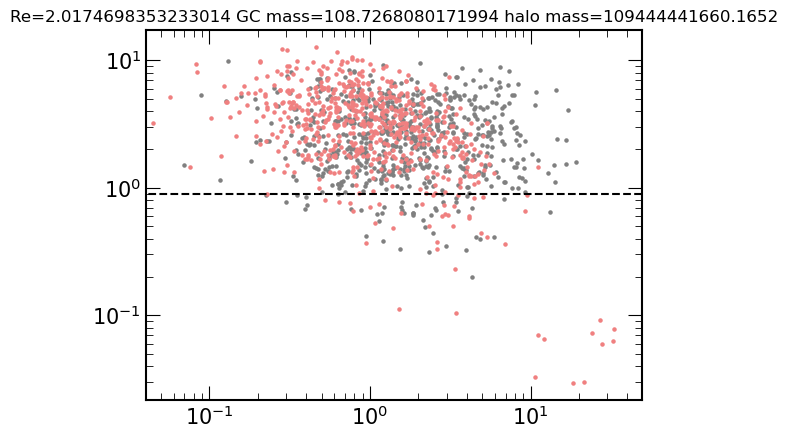

Calculating NFW Energies and Weights


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/ipykernel_launcher.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Finished calculating NFW Energies and Weights
6.146445989608765
1 1.8560862509598706
finished until t = 0.0 2.4087119102478027
finished until t = 0.5 41.54531192779541
finished until t = 1.0 118.24578499794006
finished until t = 1.5 235.01291680335999
finished until t = 2.0 390.111967086792
finished until t = 2.5 585.6902267932892
finished until t = 3.0 820.1140556335449
finished until t = 3.5 1104.8928985595703
finished until t = 4.0 1418.7893362045288
finished until t = 4.5 1771.6634557247162
finished until t = 5.0 2200.94993185997
finished until t = 5.5 2636.965675354004
finished until t = 6.0 3111.0000388622284
finished until t = 6.5 3624.809144973755
finished until t = 7.0 4171.363586187363
finished until t = 7.5 4750.030440092087
finished until t = 8.0 5368.392027378082
finished until t = 8.5 6013.927304506302
finished until t = 9.0 6690.398676633835


In [ ]:
#NFW

#iterate over every combination of params
for i in range(len(R_es)):
    R_e = R_es[i]
    GC_mass = GC_masses[i]
    halo_mass = halo_masses[i]
    rho0 = rho_0_func(halo_mass)
    r0 = r_0_func(halo_mass)

    R_e_rounded = round(R_e, 3)
    GC_mass_rounded = round(GC_mass, 3)
    halo_mass_rounded = round(halo_mass, 1)
    rho0_rounded = round(rho0, 2)
    r0_rounded = round(r0, 2)

    file_name = 'Sim_'+'NFW_20'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt'
    file_path = '/home/vk9342/JP_fall_2024/test_sim_run_trial_'+str(trial_num)+'/'+str(file_name)
    if not os.path.exists(file_path):
    
        ## a C implementation of friction and background forces in rebound, for speed
        clib_additional_forces = cdll.LoadLibrary("/home/vk9342/JP_fall_2024/additional_forces_files/additional_forces_rho0_"+str(rho0_rounded)+'_r0_'+str(r0_rounded) +".so")
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho0 and r0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################
    
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho0, r0))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho0, r0, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]
    
        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho0 * r0**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)
    
        #making interpolated functions for f(E) that can be called in the initialization process for speed
    
        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
    
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr
        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)
    
            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
            # Sersic radial distribution and values to draw positions with their weights
    
            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)
    
    
            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)
    
            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < GC_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)
    
                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho0, r0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)
    
                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)
    
            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces_rho0_"+str(rho0_rounded)+'_r0_'+str(r0_rounded))
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            
            # print(f"Number of particles in simulation: {sim.N}")
            # if len(sim.particles) == 0:
            #     print("No particles found in the simulation.")
            
            
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23
    
            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []
        

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            # integrating
            sim.integrate(t)
    
            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []
    
            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
            # clearing sim from memory now that we've stored everything important
            sim = None
    
            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
    
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs
    
        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
            start = time.time()
    
            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
    
                if output_time == 0:
                    # save initial data
                    f = open('/home/vk9342/JP_fall_2024/test_sim_run_trial_'+str(trial_num)+'/Sim_'+output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('/home/vk9342/JP_fall_2024/test_sim_run_trial_'+str(trial_num)+'/Sim_' +output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))
    
        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW', phi_NFW, clib_additional_forces.NFW_DF_Updated, [rho0, r0], NFW_f_interp)

        data_initial = np.genfromtxt('/home/vk9342/JP_fall_2024/test_sim_run_trial_'
                                     +str(trial_num)+'/Sim_'+'NFW_0'+'_'+str(R_e_rounded)+'_'
                                     +str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 
                                     skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('/home/vk9342/JP_fall_2024/test_sim_run_trial_'+str(trial_num)
                                   +'/Sim_'+'NFW_20_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'
                                   +str(halo_mass_rounded)
                                   +'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
    
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' GC mass='+str(GC_mass)+' halo mass='+str(halo_mass))
        # plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()


    else:
        print('File already exists')
